# Train and test DNN models for parking space prediction

In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
target_time_period= 'july'
#target_time_period= 'sept_oct'

## General functions

In [3]:
def read_clean_subflows_fn(critera, time_period):
    subflows= {}
    for c in critera:
        df = pd.read_csv(os.path.join('data', 'INE_subflows','flow_criterion_{}_clean_{}.csv'.format(c, time_period)),
                       parse_dates=[0], index_col=0)
        subflows[c] = df
    return subflows

## Read zones 1 parking data (target variable)

In [4]:
zone1_df = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'zone1.csv'), sep=';', parse_dates=['recvTime'], index_col='recvTime')

In [5]:
zone1_df.head()

,free
recvTime,
2020-07-13 10:00:00,167.363636
2020-07-13 11:00:00,246.157895
2020-07-13 12:00:00,351.465909
2020-07-13 13:00:00,404.080000
2020-07-13 14:00:00,362.413238


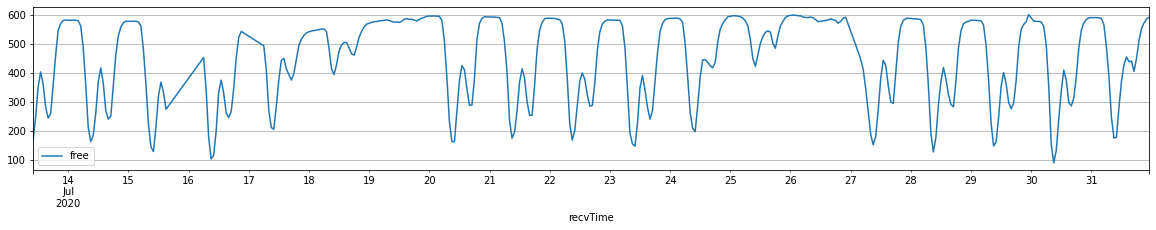

In [6]:
zone1_df.plot(figsize=(20,3),grid=True);

In [7]:
target_days = zone1_df.index

## Read subflows

In [8]:
target_criteria = range(6,11)

In [9]:
mob_flows = read_clean_subflows_fn(target_criteria, target_time_period)

In [ ]:
meteor = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'meteor.txt'), sep=';', parse_dates={'date': ['fecha', 'hora']}, index_col='date')
meteor

## Read meteorological data

In [221]:
meteor = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'meteor.txt'), sep=';', parse_dates={'date': ['fecha', 'hora']}, index_col='date')
meteor

,tmed,tmax,tmin,hrmed,hrmax,hrmin,radmed,radmax,vvmed,vvmax,dvmed,prec,dewpt,dpv
date,,,,,,,,,,,,,,
2020-07-13 09:00:00,29.9,30.9,29.0,39.5,43.9,34.5,768.7,845.0,1.3,3.5,47.3,0.0,14.6,2.6
2020-07-13 10:00:00,31.6,32.8,30.8,36.0,39.9,32.2,887.5,929.0,1.4,4.3,44.7,0.0,14.7,3.0
2020-07-13 11:00:00,33.0,34.2,32.1,31.8,35.0,29.1,954.2,978.0,1.7,5.2,39.0,0.0,14.0,3.4
2020-07-13 12:00:00,33.4,33.9,32.7,29.4,32.4,25.4,965.5,974.0,1.9,5.0,61.1,0.0,13.1,3.6
2020-07-13 13:00:00,33.9,34.6,33.4,25.8,28.9,20.9,923.3,958.0,2.1,5.4,53.3,0.0,11.6,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 19:00:00,30.8,32.5,29.4,52.2,59.0,45.8,1.2,10.8,0.5,1.9,1.0,0.0,19.8,2.1
2020-07-31 20:00:00,28.7,29.5,28.1,61.1,62.8,58.9,0.0,0.0,0.2,1.1,339.4,0.0,20.5,1.5
2020-07-31 21:00:00,28.4,29.0,27.8,61.3,62.9,60.2,0.0,0.0,0.3,1.3,260.6,0.0,20.3,1.5


In [222]:
meteor = meteor.iloc[:,[0,6,8,11]]
meteor

,tmed,radmed,vvmed,prec
date,,,,
2020-07-13 09:00:00,29.9,768.7,1.3,0.0
2020-07-13 10:00:00,31.6,887.5,1.4,0.0
2020-07-13 11:00:00,33.0,954.2,1.7,0.0
2020-07-13 12:00:00,33.4,965.5,1.9,0.0
2020-07-13 13:00:00,33.9,923.3,2.1,0.0
...,...,...,...,...
2020-07-31 19:00:00,30.8,1.2,0.5,0.0
2020-07-31 20:00:00,28.7,0.0,0.2,0.0
2020-07-31 21:00:00,28.4,0.0,0.3,0.0


## Format data

In [10]:
n_steps = 12
T_ = 1

In [179]:
#input: flow(t), flow(t-1), ..,flow(t-prev_hours). output: parking(t+T)
def generate_univariate_time_series_fn(zone_parking, subflow, prev_hours, T=1):
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_value = zone_parking.iloc[prev_hours + i +T -1]
        s = np.append(mob_values,parking_value).reshape(-1,prev_hours+1)
        series.append(s)
    series= np.array(series)
    series = series.reshape(series.shape[0],prev_hours+1,1)
    return series

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,
#parking(t-prev_hours),. output: parking(t+T)
def generate_univariate_time_series_fn2(zone_parking, subflow, prev_hours, T=1): 
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking.iloc[i:(prev_hours + i +T)]
        s = np.append(mob_values,parking_values).reshape(-1,prev_hours*2+1)
        series.append(s)
    series= np.array(series)
    series = series.reshape(series.shape[0],prev_hours*2+1,1)
    return series

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,
#parking(t-prev_hours), meteor(t), meteor(t-1), ..., meteor(t-prev_hours) output: parking(t+T)
def generate_univariate_time_series_fn3(zone_parking, subflow, meteoro, prev_hours, T=1): 
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking.iloc[i:(prev_hours + i +T -1)]
        meteor_values = meteoro.loc[i:(prev_hours + i +T -2)]
        mob_values_d = pd.DataFrame(mob_values)
        mob_values_d.index += i
        parking_value_to_predict = zone_parking.iloc[prev_hours + i +T -1]
         #s = np.append(mob_values,meteor,parking_values).reshape(-1,prev_hours*2)
        s = pd.concat([mob_values_d,meteor_values, parking_values], axis=1)
        s = s.T.to_numpy().reshape(-1)
        #s = s.append(parking_value_to_predict)
        s = np.append(s, parking_value_to_predict)
        series.append(s)
    series2 = np.asarray(series, dtype=np.float32)
    return series2

In [12]:
def generate_time_series_for_rnn_fn(zone_parking, subflow, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        X.append(mob_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,1)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

In [13]:
#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,#parking(t-prev_hours),. 
#output: parking(t+1), parking (t+2),..,parking(t+T)
def generate_time_series_for_rnn_fn2(zone_parking, subflow, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:i+prev_hours].values
        two_dim_values = np.concatenate((mob_values, parking_values), axis=0)#.reshape(-1,2)
        X.append(two_dim_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,2)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

In [14]:
a =np.array([1,2,3])
b =np.array([4,5,6])

In [15]:
np.concatenate((a, b), axis=0)


array([1, 2, 3, 4, 5, 6])

In [16]:
np.concatenate((a, b), axis=0).reshape(-1,2)


array([[1, 2],
       [3, 4],
       [5, 6]])

### Scale data

In [17]:
scaler_flow =  StandardScaler()
flow_scaled = scaler_flow.fit_transform(mob_flows[9].loc[target_days].values)
flow_scaled_df = pd.DataFrame(flow_scaled)
flow_scaled_df.head()

,0
0,1.050581
1,0.537342
2,0.377285
3,0.498533
4,1.536396


In [18]:
scaler_parking =  StandardScaler()
zone_scaled =scaler_parking.fit_transform(zone1_df.values)
parking_scaled_df = pd.DataFrame(zone_scaled)
parking_scaled_df.head()

,0
0,-2.046244
1,-1.477782
2,-0.718037
3,-0.338452
4,-0.639057


In [223]:
scaler_meteor =  StandardScaler()
meteor_scaled =scaler_meteor.fit_transform(meteor.loc[target_days].values)
meteor_scaled_df = pd.DataFrame(meteor_scaled)
meteor_scaled_df.head()

,0,1,2,3
0,0.753114,1.570573,0.615937,-0.060552
1,1.048587,1.754888,1.047641,-0.060552
2,1.133008,1.786113,1.335444,-0.060552
3,1.238534,1.669501,1.623247,-0.060552
4,1.069692,1.395101,2.054951,-0.060552


### Generate time series samples

In [139]:
ts = generate_univariate_time_series_fn(parking_scaled_df, flow_scaled_df, n_steps, T_)
ts[0]

array([[ 1.05058106],
       [ 0.53734227],
       [ 0.37728519],
       [ 0.49853284],
       [ 1.53639552],
       [ 0.78392941],
       [ 1.05006241],
       [ 0.83789911],
       [ 1.10564543],
       [ 1.02231909],
       [ 0.38188192],
       [-0.26148127],
       [ 0.93845406]])

In [187]:
ts3 = generate_univariate_time_series_fn3(parking_scaled_df, flow_scaled_df, meteor_scaled_df, n_steps, T_)
ts3[0]

array([ 1.0505811 ,  0.53734225,  0.37728518,  0.49853283,  1.5363955 ,
        0.7839294 ,  1.0500624 ,  0.8378991 ,  1.1056454 ,  1.0223191 ,
        0.38188192, -0.26148126,  0.75311434,  1.048587  ,  1.1330076 ,
        1.2385336 ,  1.0696921 ,  1.0063765 ,  0.9219558 ,  0.6686936 ,
        0.2888003 , -0.15440854, -0.4498811 , -0.5976174 ,  0.8138622 ,
        1.1004004 ,  1.0389994 ,  1.1822685 ,  1.0389994 ,  0.9161973 ,
        0.8752633 ,  0.73199415,  0.40452188, -0.10715356, -0.49602687,
       -0.65976304,  0.76898766,  1.0521806 ,  1.182885  ,  1.3353736 ,
        1.0957488 ,  1.1175328 ,  0.9650443 ,  0.7254195 ,  0.20260167,
       -0.23307984, -0.40735245, -0.51627284, -0.8382285 , -1.0718986 ,
       -1.2054244 , -1.4057131 , -1.1998608 , -1.172043  , -1.1776065 ,
       -0.93837285, -0.61012197, -0.24848966,  0.29674056,  0.5637921 ,
       -0.8154526 , -1.0925791 , -1.2396259 , -1.4375734 , -1.2452816 ,
       -1.2792155 , -1.1943808 , -1.0529896 , -0.58922684, -0.18

In [60]:
ts.shape

(433, 25, 1)

In [21]:
n_series = ts.shape[0]

## Split training-test

In [22]:
training_rate = 0.9

In [25]:
n_series_training = round(n_series * training_rate)


In [26]:
X_train, y_train = ts[:n_series_training,:n_steps], ts[:n_series_training, -1]
X_valid, y_valid = ts[n_series_training:,:n_steps], ts[n_series_training:, -1]

In [27]:
X_train.shape, y_train.shape

((390, 12, 1), (390, 1))

In [28]:
X_valid.shape, y_valid.shape

((43, 12, 1), (43, 1))

In [203]:
def generate_train_test(zone_parking, subflow, meteoro =[], prev_hours = 12, T=1, fun =1, tr= 0.9, nfeatures=1):
    if(fun==1):
        ts = generate_univariate_time_series_fn(zone_parking, subflow, n_steps, T_)
    if(fun==2): 
        ts = generate_univariate_time_series_fn2(zone_parking, subflow, n_steps, T_)
    else:
        ts = generate_univariate_time_series_fn3(zone_parking, subflow, meteoro, n_steps, T_)
    n_series = ts.shape[0]
    training_rate = tr
    n_series_training = round(n_series * training_rate)
    X_train, y_train = ts[:n_series_training,:n_steps*nfeatures], ts[:n_series_training, -1]
    X_valid, y_valid = ts[n_series_training:,:n_steps*nfeatures], ts[n_series_training:, -1]
    return X_train, y_train, X_valid, y_valid

In [30]:
def generate_train_test_for_rnn(zone_parking, subflow, prev_hours, T=1, fun =1, tr= 0.9):
    if(fun==1):
        X,Y = generate_time_series_for_rnn_fn(zone_parking, subflow, n_steps, T_)
    else: 
        X,Y = generate_time_series_for_rnn_fn2(zone_parking, subflow, n_steps, T_)

    n_train_samples = round(X.shape[0] * tr)
    X_train = X[:n_train_samples]
    y_train = Y[:n_train_samples]

    X_valid = X[n_train_samples:]
    y_valid = Y[n_train_samples:]
      
    return X_train, y_train, X_valid, y_valid

## Test DNN models

In [31]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    #plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [32]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [33]:
def compute_metrics_fn(y_valid, y_hat, scaler):
    ## actual train and test values
    y_hat_resc = scaler_parking.inverse_transform(y_hat)
    y_valid_resc = scaler_parking.inverse_transform(y_valid)

    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [34]:
def plot_prediction_vs_groundtruth_fn(y_valid, y_hat):
    y_hat_resc = scaler_parking.inverse_transform( y_hat[:,-1].reshape(-1,))
    y_valid_resc = scaler_parking.inverse_transform(y_valid[:,-1].reshape(-1,))
    plt.plot(np.arange(len(y_hat_resc)), y_hat_resc, "b.-", label="y_hat")
    plt.plot(np.arange(len(y_valid_resc)), y_valid_resc, "r.-", label="y_true")
    plt.legend(fontsize=14)
    plt.xlabel("Timestamp")
    plt.ylabel("Free places")
    plt.grid(True)

### MLP - benchmark

In [35]:
import tensorflow as tf
from tensorflow import keras

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps, 1]),
    keras.layers.Dense(1)
])

model_mlp.compile(loss="mse", optimizer="adam")
history = model_mlp.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
13/13 [==============================] - 0s 29ms/step - loss: 1.2167 - val_loss: 1.3824
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 1.1351 - val_loss: 1.2606
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 1.0603 - val_loss: 1.1596
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 1.0003 - val_loss: 1.0710
Epoch 5/100
13/13 [==============================] - 0s 2ms/step - loss: 0.9568 - val_loss: 0.9869
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.9136 - val_loss: 0.9232
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.8852 - val_loss: 0.8644
Epoch 8/100
13/13 [==============================] - 0s 8ms/step - loss: 0.8609 - val_loss: 0.8215
Epoch 9/100
13/13 [==============================] - 0s 7ms/step - loss: 0.8416 - val_loss: 0.7802
Epoch 10/100
13/13 [==============================] - 0s 7ms/step - loss: 0.8272 - val_loss: 0.7450
Epoch 11

Epoch 83/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5581 - val_loss: 0.3968
Epoch 84/100
13/13 [==============================] - 0s 6ms/step - loss: 0.5572 - val_loss: 0.4005
Epoch 85/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5563 - val_loss: 0.3992
Epoch 86/100
13/13 [==============================] - 0s 6ms/step - loss: 0.5549 - val_loss: 0.4014
Epoch 87/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5546 - val_loss: 0.4073
Epoch 88/100
13/13 [==============================] - 0s 9ms/step - loss: 0.5538 - val_loss: 0.4075
Epoch 89/100
13/13 [==============================] - 0s 7ms/step - loss: 0.5528 - val_loss: 0.4045
Epoch 90/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5518 - val_loss: 0.3942
Epoch 91/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5511 - val_loss: 0.3903
Epoch 92/100
13/13 [==============================] - 0s 8ms/step - loss: 0.5500 - val_loss: 0.3853


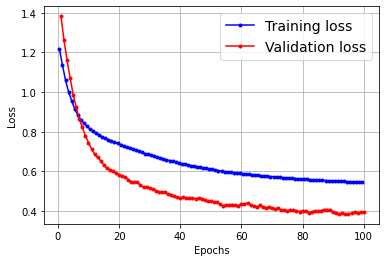

In [37]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [38]:
y_hat = model_mlp.predict(X_valid)

#### Get metrics

In [39]:
mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid, y_hat, scaler_parking)

print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))

MAE: 73.932, MSE: 7553.531, RMSE: 86.911, CVRMSE: 20.408, MAPE: 26.495


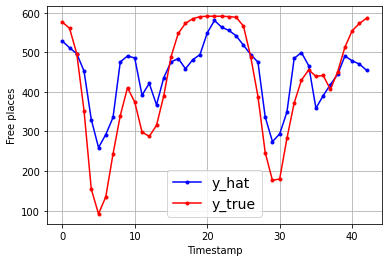

In [40]:
plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

In [94]:
def mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=1):
    np.random.seed(42)
    tf.random.set_seed(42)

    model_mlp = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[n_steps*nfeatures, 1]),
        keras.layers.Dense(1)
    ])

    model_mlp.compile(loss="mse", optimizer="adam")
    history = model_mlp.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_valid, y_valid))
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    y_hat = model_mlp.predict(X_valid)
    mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid, y_hat, scaler_parking)
    print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))
    plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

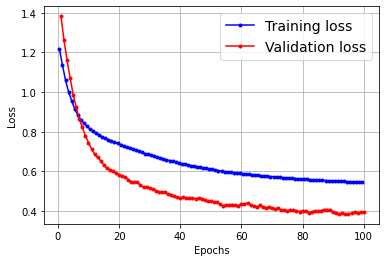

MAE: 73.932, MSE: 7553.531, RMSE: 86.911, CVRMSE: 20.408, MAPE: 26.495


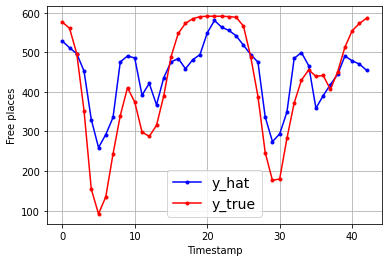

In [53]:
# Model with flows as inputs
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, flow_scaled_df, 12, T=1)
mlp_benchmark(X_train, y_train, X_valid, y_valid)

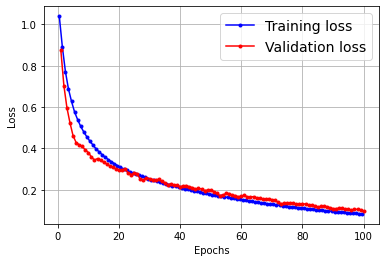

MAE: 31.091, MSE: 1881.433, RMSE: 43.375, CVRMSE: 10.185, MAPE: 10.979


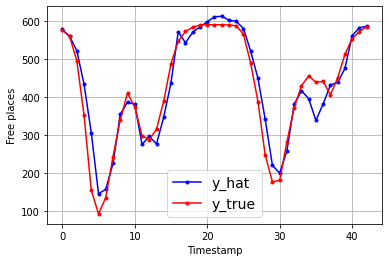

In [95]:
# Model with flows and parking as inputs
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, flow_scaled_df, 
                                                         12, T=1, fun = 2, nfeatures=2)
mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=2)

In [227]:
# Model with flows, parkings and meteorological data as inputs
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, flow_scaled_df, 
                                                         meteor_scaled_df,
                                                         12, T=1, fun = 3, nfeatures=6)
#mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=6) # NO VA EN LA FUNCIÓN EN SÍ
# PORQUE HAY QUE HACERLE ALGO AL Y_HAT QUE SALE EN FORMA DE COLUMNA... NO LO CONSIGO PERO LO DEJO ABAJO

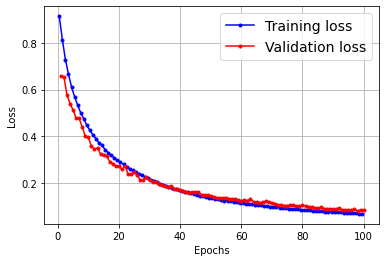

MAE: 30.400, MSE: 1635.465, RMSE: 40.441, CVRMSE: 9.496, MAPE: 55.252


In [259]:
nfeatures=6
np.random.seed(42)
tf.random.set_seed(42)

model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps*nfeatures, 1]),
    keras.layers.Dense(1)
])

model_mlp.compile(loss="mse", optimizer="adam")
history = model_mlp.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_valid, y_valid))
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
y_hat = model_mlp.predict(X_valid)
mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid, y_hat, scaler_parking)
print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))
#plot_prediction_vs_groundtruth_fn(y_valid, y_hat.reshape)


In [258]:
y_hat2 = y_hat.reshape(-1)
print(y_valid)
print(y_hat2)
plot_prediction_vs_groundtruth_fn(y_valid, y_hat2)


[ 9.0475202e-01  7.9036927e-01  3.2590801e-01 -7.1021909e-01
 -2.1405933e+00 -2.5911069e+00 -2.2799175e+00 -1.5002372e+00
 -7.9978597e-01 -2.9173401e-01 -5.5312216e-01 -1.0991052e+00
 -1.1790227e+00 -9.7816420e-01 -4.4034788e-01  2.6818043e-01
  6.9785595e-01  8.8179576e-01  9.6420801e-01  1.0026795e+00
  1.0100838e+00  1.0100838e+00  1.0100838e+00  1.0038313e+00
  9.9084514e-01  8.3044255e-01  2.7400726e-01 -4.5232856e-01
 -1.4733642e+00 -1.9798898e+00 -1.9542919e+00 -1.2131436e+00
 -5.6873471e-01 -1.5345781e-01  3.3019029e-02 -8.4370449e-02
 -6.9188327e-02 -3.2315913e-01 -1.6506888e-03  4.4663283e-01
  7.4484456e-01  8.7932086e-01  9.7401130e-01]
[ 1.0230258   0.7773697   0.38652042 -0.08276627 -1.4331434  -2.0167544
 -2.2200327  -1.7009374  -0.85820436 -0.6677335  -0.59621817 -0.80086976
 -1.0997121  -1.2365508  -0.7339086   0.22709516  0.6846596   0.98530865
  1.0443189   0.7037479   0.9784972   0.83575064  1.0382984   0.97210926
  0.96002895  0.85965854  0.62973887 -0.02954519 -1.

IndexError: too many indices for array

###  GRU model

In [42]:
def gru_model(X_train, y_train, X_valid, y_valid, fun=1):
    np.random.seed(42)
    tf.random.set_seed(42)

    model_gru = keras.models.Sequential([
        keras.layers.LSTM(20, return_sequences=True,  input_shape=[None, fun]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10)),
        keras.layers.Dense(1)
    ])

    model_gru.compile(loss="mse", optimizer="adam")
    history = model_gru.fit(X_train, y_train, verbose=0, epochs=100, validation_data=(X_valid, y_valid))
    
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    
    y_hat = model_gru.predict(X_valid)

    mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid[:,-1].reshape(-1,), y_hat[:,-1].reshape(-1,), scaler_parking)

    print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))
    
    plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

Only with flow as input

In [43]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, flow_scaled_df, 12, T=1, fun=1)

In [44]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((390, 12, 1), (390, 12, 1), (43, 12, 1), (43, 12, 1))

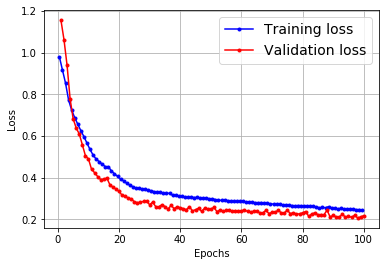

MAE: 36.616, MSE: 1815.332, RMSE: 42.607, CVRMSE: 10.005, MAPE: 12.104


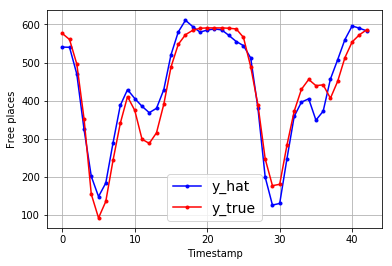

In [45]:
gru_model(X_train, y_train, X_valid, y_valid)

Now we try with flow + parking as input

In [46]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, flow_scaled_df, 12, T=1, fun=2)

In [47]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((390, 12, 2), (390, 12, 1), (43, 12, 2), (43, 12, 1))

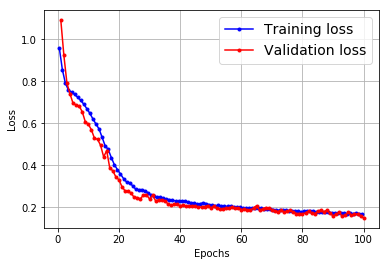

MAE: 28.388, MSE: 1361.585, RMSE: 36.900, CVRMSE: 8.665, MAPE: 8.792


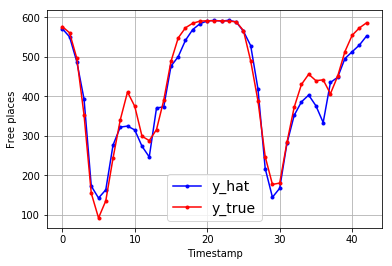

In [48]:
gru_model(X_train, y_train, X_valid, y_valid, 2)

------------------------------------

In [49]:
print("That's all folks!")

That's all folks!
